<a href="https://colab.research.google.com/github/garlicxd/Fruit-Classification/blob/main/Fruit_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Todo
- [ ] patience for training - stopping after no improvement for several epochs
- [ ] create graphs - store information while training
- [ ] compare different optimizers

In [ ]:
# @title Download Dataset

# Define the path for the target dataset folder
dataset_folder_path = "./split_ttv_dataset_type_of_plants"

!pip install kaggle
from google.colab import files
import os
kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
if not os.path.exists(kaggle_json_path):
    print("kaggle.json not found. Please upload your kaggle.json file:")
    uploaded = files.upload()
    if "kaggle.json" in uploaded:
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("Kaggle API key configured successfully!")
    else:
        print("Upload failed or kaggle.json not found in upload.")
else:
    print("Kaggle API key already configured.")

if not os.path.exists(dataset_folder_path):
    print(f"Dataset folder '{dataset_folder_path}' not found. Downloading and unzipping...")
    !kaggle datasets download -d yudhaislamisulistya/plants-type-datasets
    !unzip -q plants-type-datasets.zip
    print("Dataset downloaded and unzipped successfully.")
else:
    print(f"Dataset folder '{dataset_folder_path}' already exists. Skipping download and unzip.")

print("\nClasses in training directory:")
!ls ./split_ttv_dataset_type_of_plants/Train_Set_Folder/

kaggle.json not found. Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API key configured successfully!
Dataset folder './split_ttv_dataset_type_of_plants' not found. Downloading and unzipping...
Dataset URL: https://www.kaggle.com/datasets/yudhaislamisulistya/plants-type-datasets
License(s): copyright-authors
 98% 923M/937M [00:12<00:00, 225MB/s]
100% 937M/937M [00:12<00:00, 81.4MB/s]
Dataset downloaded and unzipped successfully.

Classes in training directory:
 aloevera     coconut	 galangal    mango   'peper chili'   spinach
 banana       corn	 ginger      melon    pineapple     'sweet potatoes'
 bilimbi      cucumber	 guava	     orange   pomelo	     tobacco
 cantaloupe   curcuma	 kale	     paddy    shallot	     waterapple
 cassava      eggplant	 longbeans   papaya   soybeans	     watermelon


In [ ]:
# @title Parameters and Includes

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import os
import glob
import shutil
import json
import time
from tqdm.notebook import tqdm
import numpy as np

BASE_DIR = './split_ttv_dataset_type_of_plants'
BASE_TRAIN_DIR = os.path.join(BASE_DIR, 'Train_Set_Folder')
BASE_VAL_DIR = os.path.join(BASE_DIR, 'Validation_Set_Folder')
BASE_TEST_DIR = os.path.join(BASE_DIR, 'Test_Set_Folder')
SHUFFLE_TRAINING = True

CLASSES_TO_USE = ["aloevera", "banana", "bilimbi", "cantaloupe", "cassava", "coconut", "corn", "cucumber", "curcuma", "eggplant", "galangal", "ginger", "guava", "kale", "longbeans", "mango", "melon", "orange", "paddy", "papaya", "peper chili", "pineapple", "pomelo", "shallot", "soybeans", "spinach", "sweet potatoes", "tobacco", "waterapple", "watermelon"]

MAX_IMAGES_PER_CLASS_TRAIN = 1000

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 5
MODEL_SAVE_PATH = './barebones_resnet50.pth'
CLASS_MAP_PATH = './class_mapping.json'
IMG_AUGMENT = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Classes to train: {', '.join(CLASSES_TO_USE)}")
print(f"Max training images per class: {MAX_IMAGES_PER_CLASS_TRAIN}")
print(f"Include augmented images: {IMG_AUGMENT}")

Using device: cuda
Classes to train: aloevera, banana, bilimbi, cantaloupe, cassava, coconut, corn, cucumber, curcuma, eggplant, galangal, ginger, guava, kale, longbeans, mango, melon, orange, paddy, papaya, peper chili, pineapple, pomelo, shallot, soybeans, spinach, sweet potatoes, tobacco, waterapple, watermelon
Max training images per class: 1000
Include augmented images: False


In [ ]:
# @title Filtered Set Creation

base_filtered_dir = './filtered_data'
filtered_train_dir = os.path.join(base_filtered_dir, 'train')
filtered_val_dir = os.path.join(base_filtered_dir, 'val')
filtered_test_dir = os.path.join(base_filtered_dir, 'test')

if os.path.exists(base_filtered_dir):
    print(f"Removing existing filtered data directory: {base_filtered_dir}")
    shutil.rmtree(base_filtered_dir)

class_to_idx = {}
idx_to_class = []

print("Creating filtered training set...")
for i, class_name in enumerate(CLASSES_TO_USE):
    class_to_idx[class_name] = i
    idx_to_class.append(class_name)

    source_dir = os.path.join(BASE_TRAIN_DIR, class_name)
    dest_dir = os.path.join(filtered_train_dir, class_name)
    os.makedirs(dest_dir, exist_ok=True)

    all_images = glob.glob(os.path.join(source_dir, '*.*'))
    if IMG_AUGMENT:
        images_to_copy = [img for img in all_images if os.path.basename(img).startswith('aug_')][:MAX_IMAGES_PER_CLASS_TRAIN]
    else:
        images_to_copy = [img for img in all_images if not os.path.basename(img).startswith('aug_')][:MAX_IMAGES_PER_CLASS_TRAIN]


    for img_path in images_to_copy:
        shutil.copy(img_path, dest_dir)
print(f"Filtered training set created at: {filtered_train_dir}")

print("Creating filtered validation set...")
for class_name in CLASSES_TO_USE:
    source_dir = os.path.join(BASE_VAL_DIR, class_name)
    dest_dir = os.path.join(filtered_val_dir, class_name)
    os.makedirs(dest_dir, exist_ok=True)

    all_images = glob.glob(os.path.join(source_dir, '*.*'))
    if IMG_AUGMENT:
        images_to_copy = [img for img in all_images if os.path.basename(img).startswith('aug_')]
    else:
        images_to_copy = [img for img in all_images if not os.path.basename(img).startswith('aug_')]

    for img_path in images_to_copy:
        shutil.copy(img_path, dest_dir)
print(f"Filtered validation set created at: {filtered_val_dir}")

print("Creating filtered test set...")
for class_name in CLASSES_TO_USE:
    source_dir = os.path.join(BASE_TEST_DIR, class_name)
    dest_dir = os.path.join(filtered_test_dir, class_name)
    os.makedirs(dest_dir, exist_ok=True)

    all_images = glob.glob(os.path.join(source_dir, '*.*'))
    if IMG_AUGMENT:
        images_to_copy = [img for img in all_images if os.path.basename(img).startswith('aug_')]
    else:
        images_to_copy = [img for img in all_images if not os.path.basename(img).startswith('aug_')]

    for img_path in images_to_copy:
        shutil.copy(img_path, dest_dir)
print(f"Filtered test set created at: {filtered_test_dir}")

with open(CLASS_MAP_PATH, 'w') as f:
    json.dump(class_to_idx, f)
print(f"Class mapping saved to {CLASS_MAP_PATH}")

NUM_CLASSES = len(CLASSES_TO_USE)

Creating filtered training set...
Filtered training set created at: ./filtered_data/train
Creating filtered validation set...
Filtered validation set created at: ./filtered_data/val
Creating filtered test set...
Filtered test set created at: ./filtered_data/test
Class mapping saved to ./class_mapping.json


In [ ]:
# @title Define Transforms and DataLoaders

imgnet_mean = [0.485, 0.456, 0.406]
imgnet_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=imgnet_mean, std=imgnet_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=imgnet_mean, std=imgnet_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=imgnet_mean, std=imgnet_std)
    ]),
}

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(filtered_train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(filtered_val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(filtered_test_dir, data_transforms['test'])
}

# Create dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAINING),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(f"Total training images: {dataset_sizes['train']}")
print(f"Total validation images: {dataset_sizes['val']}")
print(f"Total test images: {dataset_sizes['test']}")

Total training images: 2406
Total validation images: 314
Total test images: 280


In [ ]:
# @title Define the Model (ResNet50) and Freeze Layers

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

for param in model.parameters():
    param.requires_grad = False #freezes

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(DEVICE)

print("Model definition complete. New final layer:")
print(model.fc)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 53.5MB/s]


Model definition complete. New final layer:
Linear(in_features=2048, out_features=30, bias=True)


In [ ]:
# @title Define Loss and Optimizer

criterion = nn.CrossEntropyLoss()

# Should use Adam for best results but check SGD parameters first
optimizer = optim.SGD(model.fc.parameters(), lr=LEARNING_RATE)
print(f"Using optimizer: SGD with LR={LEARNING_RATE}")

Using optimizer: SGD with LR=0.01


In [ ]:
# @title Training Loop (with Validation)

print("Starting training...") # Indicate the start of the training process
start_time = time.time() # Record the start time of training

# To store best model weights
best_model_wts = model.state_dict() # Initialize with the current model's state dictionary
best_val_acc = 0.0 # Initialize best validation accuracy to 0

# Dictionary to store training history for plotting
history = {
    "loss": [], # List to store training loss per epoch
    "accuracy": [], # List to store training accuracy per epoch
    "val_loss": [], # List to store validation loss per epoch
    "val_accuracy": [] # List to store validation accuracy per epoch
}

# Loop through the specified number of epochs
for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---") # Print current epoch number

    # Training Phase
    model.train() # Set the model to training mode (enables gradients and dropout)

    running_loss = 0.0 # Initialize running loss for the epoch
    running_corrects = 0 # Initialize running correct predictions for the epoch

    # Create a progress bar for the training dataloader
    progress_bar = tqdm(dataloaders['train'], desc="[Train]")

    # Iterate over data in the training dataloader
    for inputs, labels in progress_bar:
        inputs = inputs.to(DEVICE) # Move inputs to the specified device (CPU/GPU)
        labels = labels.to(DEVICE) # Move labels to the specified device

        optimizer.zero_grad() # Zero the gradients of the optimizer

        outputs = model(inputs) # Forward pass: compute model outputs
        loss = criterion(outputs, labels) # Calculate the loss
        _, preds = torch.max(outputs, 1) # Get the predicted class (index of max logit)

        loss.backward() # Backpropagation: compute gradients
        optimizer.step() # Update model parameters

        batch_loss = loss.item() # Get the scalar value of the loss for the current batch
        running_loss += batch_loss * inputs.size(0) # Accumulate batch loss weighted by batch size
        running_corrects += torch.sum(preds == labels.data) # Accumulate correct predictions

        # Update progress bar with current batch loss
        progress_bar.set_postfix(batch_loss=f"{batch_loss:.4f}")

    epoch_loss = running_loss / dataset_sizes['train'] # Calculate average training loss for the epoch
    epoch_acc = running_corrects.double() / dataset_sizes['train'] # Calculate training accuracy for the epoch


    # Validation Phase
    model.eval() # Set the model to evaluation mode (disables gradients and dropout)

    val_running_loss = 0.0 # Initialize running loss for the validation set
    val_running_corrects = 0 # Initialize running correct predictions for the validation set

    # Disable gradient calculations for current epoch validation
    # Increases running speed
    with torch.no_grad():
        # Create a progress bar for the validation dataloader
        progress_bar_val = tqdm(dataloaders['val'], desc="[Validate]")
        # Iterate over data in the validation dataloader
        for inputs, labels in progress_bar_val:
            inputs = inputs.to(DEVICE) # Move inputs to the specified device
            labels = labels.to(DEVICE) # Move labels to the specified device

            outputs = model(inputs) # Forward pass: compute model outputs
            loss = criterion(outputs, labels) # Calculate the loss
            _, preds = torch.max(outputs, 1) # Get the predicted class

            val_running_loss += loss.item() * inputs.size(0) # Accumulate batch validation loss
            val_running_corrects += torch.sum(preds == labels.data) # Accumulate correct validation predictions

    val_loss = val_running_loss / dataset_sizes['val'] # Calculate average validation loss for the epoch
    val_acc = val_running_corrects.double() / dataset_sizes['val'] # Calculate validation accuracy for the epoch

    # Status update per epoch
    print(f"Epoch Summary:") # Print summary header
    print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}") # Print training loss and accuracy
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}") # Print validation loss and accuracy

    # saving evaluation values for plotting graphs later
    history["loss"].append(epoch_loss) # Append training loss to history
    history["accuracy"].append(epoch_acc.item() if hasattr(epoch_acc, "item") else float(epoch_acc)) # Append training accuracy to history
    history["val_loss"].append(val_loss) # Append validation loss to history
    history["val_accuracy"].append(val_acc.item() if hasattr(val_acc, "item") else float(val_acc)) # Append validation accuracy to history


    # Save the model if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc # Update best validation accuracy
        best_model_wts = model.state_dict() # Save the model's state dictionary
        print(f"  -> New best model found! (Val Acc: {best_val_acc:.4f})") # Indicate new best model found

time_elapsed = time.time() - start_time # Calculate total training time
print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s") # Print total training time
print(f"Best Val Acc: {best_val_acc:.4f}") # Print the best validation accuracy achieved

# Load best model weights
model.load_state_dict(best_model_wts) # Load the state dictionary of the best model

Starting training...

--- Epoch 1/5 ---


[Train]:   0%|          | 0/76 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch Summary:
  Train Loss: 3.2285 | Train Acc: 0.2527
  Val Loss:   3.0119 | Val Acc:   0.5318
  -> New best model found! (Val Acc: 0.5318)

--- Epoch 2/5 ---


[Train]:   0%|          | 0/76 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch Summary:
  Train Loss: 2.8368 | Train Acc: 0.6060
  Val Loss:   2.6598 | Val Acc:   0.6783
  -> New best model found! (Val Acc: 0.6783)

--- Epoch 3/5 ---


[Train]:   0%|          | 0/76 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch Summary:
  Train Loss: 2.4960 | Train Acc: 0.7145
  Val Loss:   2.3638 | Val Acc:   0.7102
  -> New best model found! (Val Acc: 0.7102)

--- Epoch 4/5 ---


[Train]:   0%|          | 0/76 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch Summary:
  Train Loss: 2.2012 | Train Acc: 0.7598
  Val Loss:   2.1143 | Val Acc:   0.7293
  -> New best model found! (Val Acc: 0.7293)

--- Epoch 5/5 ---


[Train]:   0%|          | 0/76 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch Summary:
  Train Loss: 1.9665 | Train Acc: 0.7901
  Val Loss:   1.9148 | Val Acc:   0.7580
  -> New best model found! (Val Acc: 0.7580)

Training complete in 1m 45s
Best Val Acc: 0.7580


<All keys matched successfully>

In [ ]:
# @title Save Best Model

print(f"Saving best model state dictionary to {MODEL_SAVE_PATH}...")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Best model saved successfully.")

Saving best model state dictionary to ./barebones_resnet50.pth...
Best model saved successfully.


In [ ]:
# @title Load Model

print("--- Loading Model for Inference ---")

print(f"Loading class mapping from {CLASS_MAP_PATH}...")
with open(CLASS_MAP_PATH, 'r') as f:
    loaded_class_to_idx = json.load(f)
LOADED_NUM_CLASSES = len(loaded_class_to_idx)
print(f"Loaded {LOADED_NUM_CLASSES} classes.")

model_to_load = models.resnet50(weights=None)
num_ftrs = model_to_load.fc.in_features
model_to_load.fc = nn.Linear(num_ftrs, LOADED_NUM_CLASSES)

print(f"Loading model weights from {MODEL_SAVE_PATH}...")
model_to_load.load_state_dict(torch.load(MODEL_SAVE_PATH))

model_to_load = model_to_load.to(DEVICE)
model_to_load.eval()

print("Model loaded successfully and set to evaluation mode.")

--- Loading Model for Inference ---
Loading class mapping from ./class_mapping.json...
Loaded 30 classes.
Loading model weights from ./barebones_resnet50.pth...
Model loaded successfully and set to evaluation mode.


In [ ]:
# @title 3. Final Testing on Test Set

print("--- Running Final Evaluation on Test Set ---")

test_running_loss = 0.0
test_running_corrects = 0

# Get a reverse mapping from index to class name
loaded_idx_to_class = {v: k for k, v in loaded_class_to_idx.items()}

# Set model to evaluation mode and disable gradients
model_to_load.eval()
with torch.no_grad():

    progress_bar_test = tqdm(dataloaders['test'], desc="[Test]")

    for inputs, labels in progress_bar_test:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model_to_load(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        test_running_loss += loss.item() * inputs.size(0)
        test_running_corrects += torch.sum(preds == labels.data)

# Calculate final test statistics
final_test_loss = test_running_loss / dataset_sizes['test']
final_test_acc = test_running_corrects.double() / dataset_sizes['test']

print("\n--- Final Test Results ---")
print(f"  Test Loss: {final_test_loss:.4f}")
print(f"  Test Acc:  {final_test_acc:.4f} ({test_running_corrects.item()}/{dataset_sizes['test']})")

--- Running Final Evaluation on Test Set ---


[Test]:   0%|          | 0/9 [00:00<?, ?it/s]


--- Final Test Results ---
  Test Loss: 1.9412
  Test Acc:  0.7321 (205/280)


Model evaluation

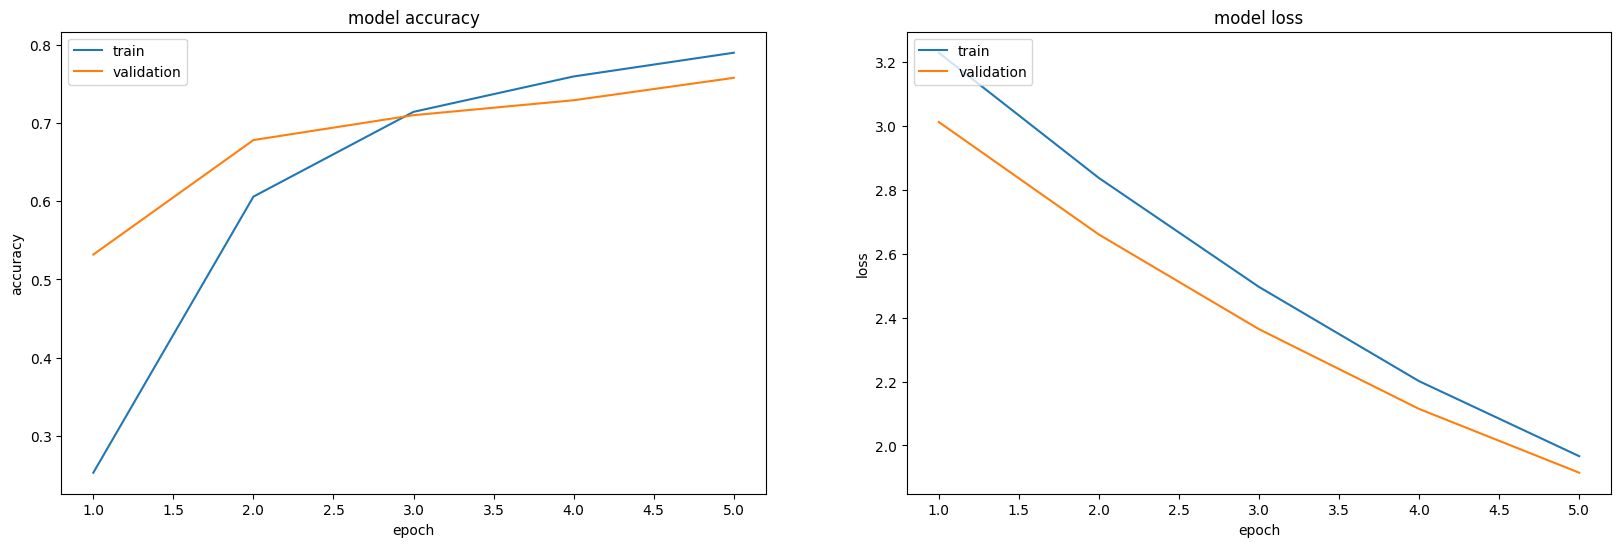

In [ ]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(20,6))

    epochs = range(1, len(history['accuracy']) + 1)

    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(epochs, history['accuracy'])
    plt.plot(epochs, history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(epochs, history['loss'])
    plt.plot(epochs, history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.show()

show_history(history)


In [ ]:
# Redefine imshow to handle normalization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))

    #undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [ ]:
# Generic function to display predictions for a few images
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print("preds: ", len(preds))

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('pred/true: {}/{}'.format(CLASSES_TO_USE[preds[j]],
                                                       CLASSES_TO_USE[labels[j]]))
                print(CLASSES_TO_USE[preds[j]] == CLASSES_TO_USE[labels[j]])
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

preds:  32
True


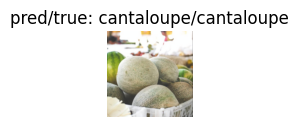

True


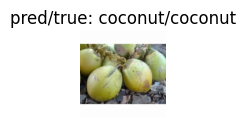

True


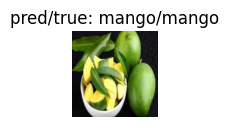

True


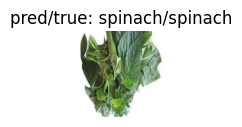

True


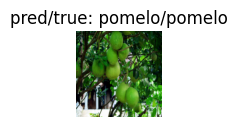

True


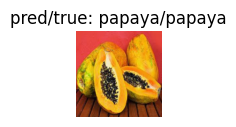

True


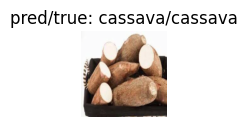

True


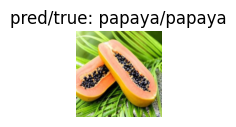

False


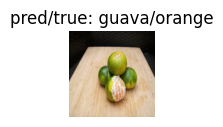

True


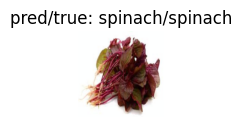

In [ ]:
visualize_model(model)

2406
2406


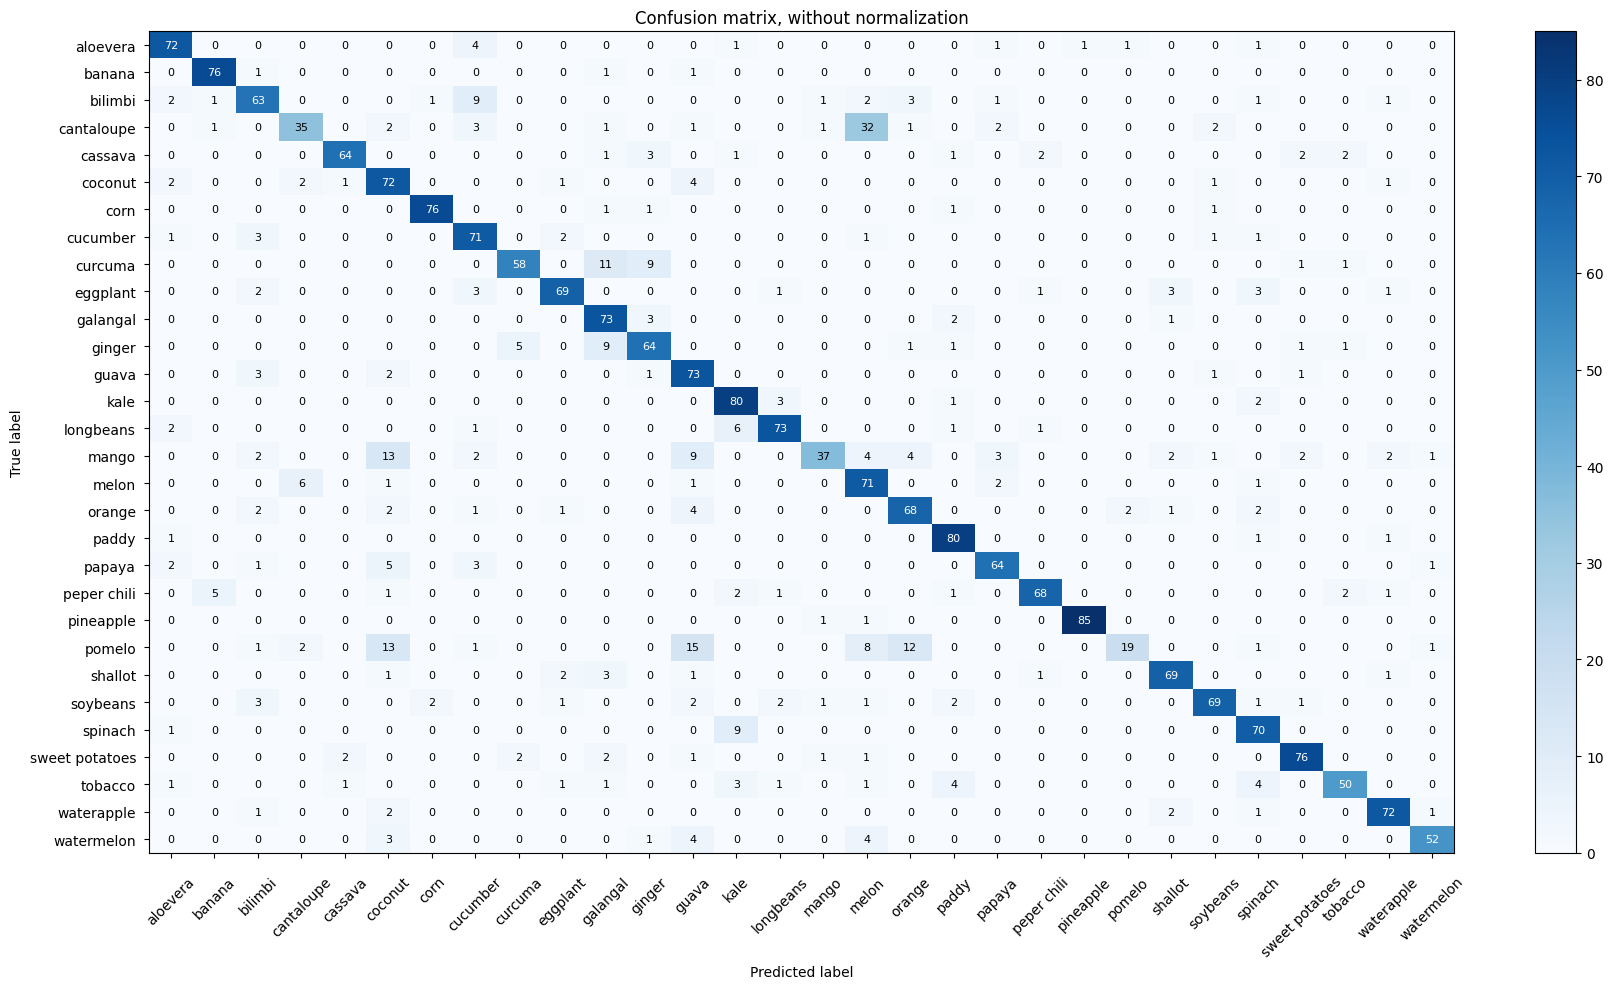

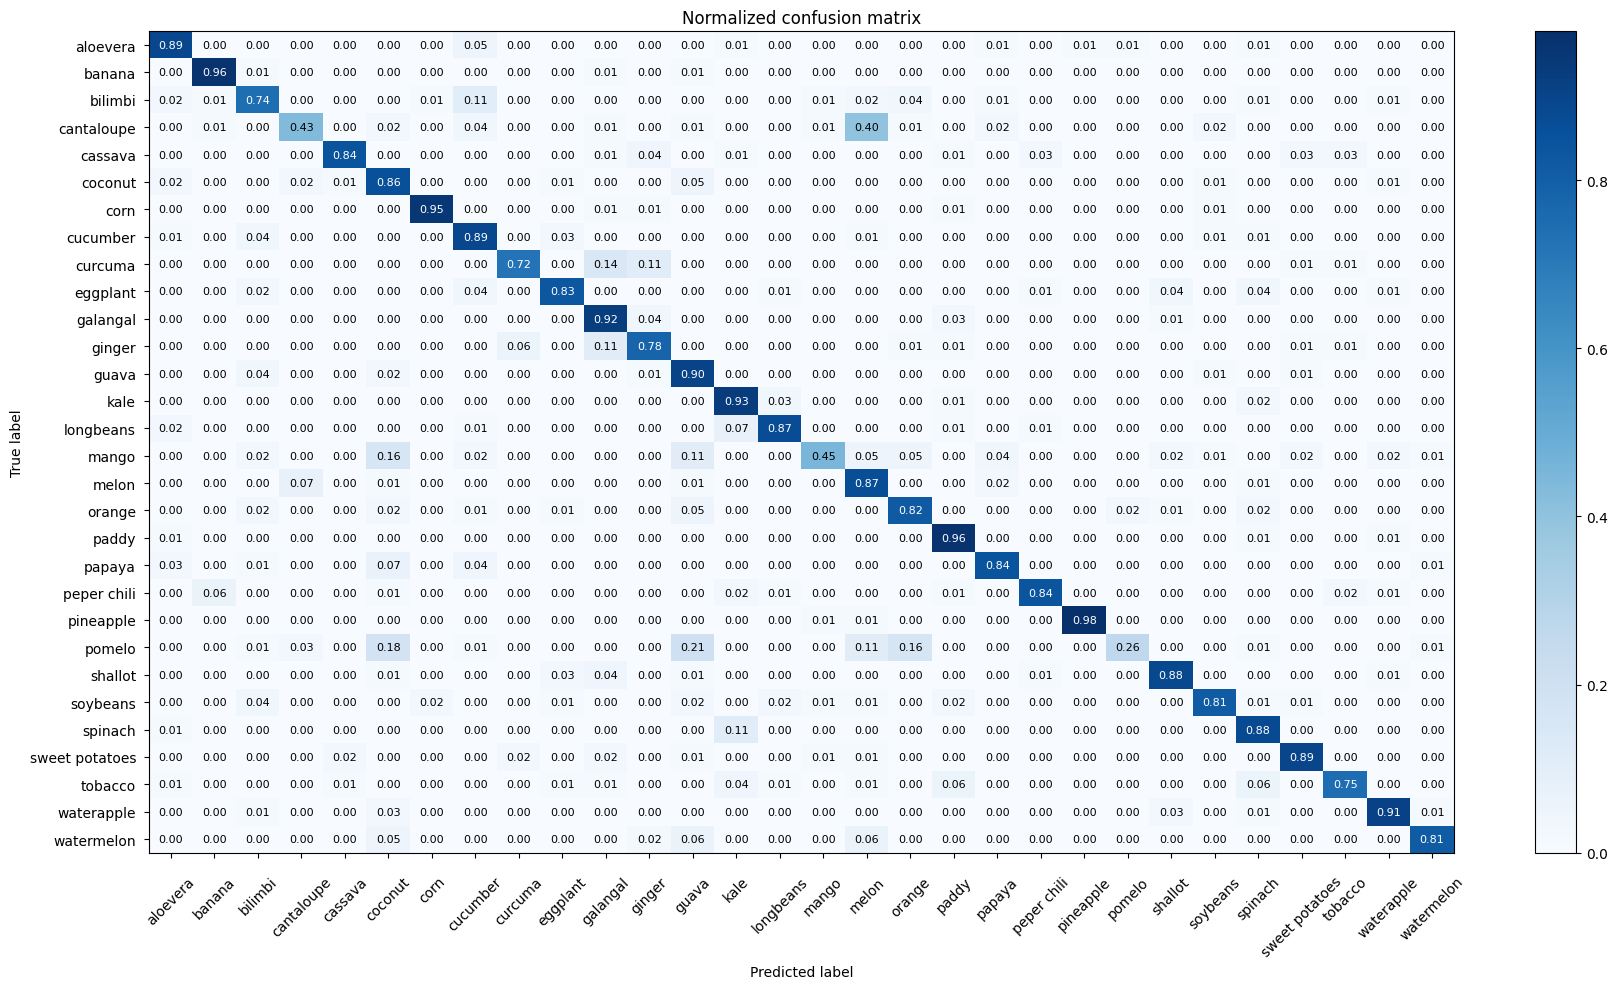

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False, title=None, cmap=plt.cm.Blues):
    if title is None:
        title = 'Normalized confusion matrix' if normalize else 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

    if normalize:
        with np.errstate(all='ignore'):
            cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)  # handle rows with zero support

    width = min(24, 0.6 * len(class_names))
    fig, ax = plt.subplots(figsize=(width, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    ax.tick_params(axis='x', labelrotation=45, pad=12)
    ax.tick_params(axis='y', pad=6)

    # give labels extra margins so they don’t clip
    fig.subplots_adjust(bottom=0.32, left=0.28)

    # annotations (smaller font helps clutter)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    fontsize=8,
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return ax

# --- Collect predictions over the FULL dataset, not just the last batch ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for inputs, y_true in dataloaders['train']:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true_all.append(y_true.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

print(len(y_true_all))
print(len(y_pred_all))
# class_names must be a list of names ordered by the class index used by the model
# If you have a torchvision ImageFolder:
#   idx_to_class = {v:k for k, v in dataset.class_to_idx.items()}
#   class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
class_names = CLASSES_TO_USE  # ensure this is a list of strings in index order

np.set_printoptions(precision=2)

# Plot
plot_confusion_matrix(y_true_all, y_pred_all, class_names, normalize=False,
                      title='Confusion matrix, without normalization')
plt.show()

plot_confusion_matrix(y_true_all, y_pred_all, class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
